In [254]:
class RandomForest():
    def __init__(self, x, y, n_trees, n_features, sample_sz, depth=10, min_leaf=5):
        np.random.seed(12)
        if n_features == 'sqrt':
            self.n_features = int(np.sqrt(x.shape[1]))
        elif n_features == 'log2':
            self.n_features = int(np.log2(x.shape[1]))
        else:
            self.n_features = n_features
#         print(self.n_features, "sha: ",x.shape[1])    
        self.x, self.y, self.sample_sz, self.depth, self.min_leaf  = x, y, sample_sz, depth, min_leaf
        self.trees = [self.create_tree() for i in range(n_trees)]

    def create_tree(self):
        idxs = np.random.permutation(len(self.y))[:self.sample_sz]
        f_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        return DecisionTree(self.x.iloc[idxs], self.y[idxs], self.n_features, f_idxs,
                    idxs=np.array(range(self.sample_sz)),depth = self.depth, min_leaf=self.min_leaf)
        
    def predict(self, x):
        return np.mean([t.predict(x) for t in self.trees], axis=0)

def std_agg(cnt, s1, s2): return math.sqrt((s2/cnt) - (s1/cnt)**2)

class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs,idxs,depth=10, min_leaf=5):
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
#         print(f_idxs)
#         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()
        
    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x<=self.split)[0]
        rhs = np.nonzero(x>self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth-1, min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth-1, min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x.values[self.idxs,var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y,sort_x = y[sort_idx], x[sort_idx]
        rhs_cnt,rhs_sum,rhs_sum2 = self.n, sort_y.sum(), (sort_y**2).sum()
        lhs_cnt,lhs_sum,lhs_sum2 = 0,0.,0.

        for i in range(0,self.n-self.min_leaf-1):
            xi,yi = sort_x[i],sort_y[i]
            lhs_cnt += 1; rhs_cnt -= 1
            lhs_sum += yi; rhs_sum -= yi
            lhs_sum2 += yi**2; rhs_sum2 -= yi**2
            if i<self.min_leaf or xi==sort_x[i+1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std*lhs_cnt + rhs_std*rhs_cnt
            if curr_score<self.score: 
                self.var_idx,self.score,self.split = var_idx,curr_score,xi

    @property
    def split_name(self): return self.x.columns[self.var_idx]
    
    @property
    def split_col(self): return self.x.values[self.idxs,self.var_idx]

    @property
    def is_leaf(self): return self.score == float('inf') or self.depth <= 0 
    

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx]<=self.split else self.rhs
        return t.predict_row(xi)

In [255]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.dates as mdates
from pandas import DatetimeIndex
import math
import seaborn as sns
sns.set(style='darkgrid', context='talk', palette='Dark2')
my_year_month_fmt = mdates.DateFormatter('%m/%y')
plt.rcParams['figure.figsize'] = (15, 9)
from datetime import datetime
import datetime
import pandas_datareader as web

In [256]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 1, 1)
df_amzn = web.DataReader('AMZN', 'yahoo', start, end) 

In [257]:
amzn_df = df_amzn
amzn_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001
2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002
2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005
2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999
2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013


In [258]:
amzn_df=amzn_df.reset_index()
amzn_df['Date'] = pd.to_datetime(amzn_df['Date'])
amzn_df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001
1,2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002
2,2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005
3,2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999
4,2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013
...,...,...,...,...,...,...,...
1505,2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961
1506,2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020
1507,2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049
1508,2019-12-30,1884.000000,1840.619995,1874.000000,1846.890015,3674700,1846.890015


In [259]:
amzn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1510 non-null   datetime64[ns]
 1   High       1510 non-null   float64       
 2   Low        1510 non-null   float64       
 3   Open       1510 non-null   float64       
 4   Close      1510 non-null   float64       
 5   Volume     1510 non-null   int64         
 6   Adj Close  1510 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.7 KB


In [260]:
start = datetime.datetime(2014, 1, 1)
end = datetime.datetime(2020, 1, 1)
gspc = web.DataReader('^GSPC', 'yahoo', start, end) 
snp = gspc
snp.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2014-01-02,1845.859985,1827.739990,1845.859985,1831.979980,3080600000,1831.979980
2014-01-03,1838.239990,1829.130005,1833.209961,1831.369995,2774270000,1831.369995
2014-01-06,1837.160034,1823.729980,1832.310059,1826.770020,3294850000,1826.770020
2014-01-07,1840.099976,1828.709961,1828.709961,1837.880005,3511750000,1837.880005
2014-01-08,1840.020020,1831.400024,1837.900024,1837.489990,3652140000,1837.489990


In [261]:
snp=snp.reset_index()
snp['Date'] = pd.to_datetime(snp['Date'])
snp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1510 entries, 0 to 1509
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1510 non-null   datetime64[ns]
 1   High       1510 non-null   float64       
 2   Low        1510 non-null   float64       
 3   Open       1510 non-null   float64       
 4   Close      1510 non-null   float64       
 5   Volume     1510 non-null   int64         
 6   Adj Close  1510 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 82.7 KB


In [262]:
snp.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2014-01-02,1845.859985,1827.739990,1845.859985,1831.979980,3080600000,1831.979980
1,2014-01-03,1838.239990,1829.130005,1833.209961,1831.369995,2774270000,1831.369995
2,2014-01-06,1837.160034,1823.729980,1832.310059,1826.770020,3294850000,1826.770020
3,2014-01-07,1840.099976,1828.709961,1828.709961,1837.880005,3511750000,1837.880005
4,2014-01-08,1840.020020,1831.400024,1837.900024,1837.489990,3652140000,1837.489990


In [263]:
amzn_df.index=DatetimeIndex(amzn_df['Date'])
snp.index=DatetimeIndex(snp['Date'])

In [264]:
X = amzn_df
print(X)

                 Date         High          Low         Open        Close  \
Date                                                                        
2014-01-02 2014-01-02   399.359985   394.019989   398.799988   397.970001   
2014-01-03 2014-01-03   402.709991   396.220001   398.290009   396.440002   
2014-01-06 2014-01-06   397.000000   388.420013   395.850006   393.630005   
2014-01-07 2014-01-07   398.470001   394.290009   395.040009   398.029999   
2014-01-08 2014-01-08   403.000000   396.040009   398.470001   401.920013   
...               ...          ...          ...          ...          ...   
2019-12-24 2019-12-24  1795.569946  1787.579956  1793.810059  1789.209961   
2019-12-26 2019-12-26  1870.459961  1799.500000  1801.010010  1868.770020   
2019-12-27 2019-12-27  1901.400024  1866.010010  1882.920044  1869.800049   
2019-12-30 2019-12-30  1884.000000  1840.619995  1874.000000  1846.890015   
2019-12-31 2019-12-31  1853.260010  1832.229980  1842.000000  1847.839966   

In [265]:
X['Stock_Price'] = (2*amzn_df.High + amzn_df.Low + amzn_df.Close)/4
X['Stock_Price']

Date
2014-01-02     397.677490
2014-01-03     399.519997
2014-01-06     394.012505
2014-01-07     397.315002
2014-01-08     400.990005
                 ...     
2019-12-24    1791.982452
2019-12-26    1852.297485
2019-12-27    1884.652527
2019-12-30    1863.877502
2019-12-31    1846.647491
Name: Stock_Price, Length: 1510, dtype: float64

In [266]:
snp['High']

Date
2014-01-02    1845.859985
2014-01-03    1838.239990
2014-01-06    1837.160034
2014-01-07    1840.099976
2014-01-08    1840.020020
                 ...     
2019-12-24    3226.429932
2019-12-26    3240.080078
2019-12-27    3247.929932
2019-12-30    3240.919922
2019-12-31    3231.719971
Name: High, Length: 1510, dtype: float64

In [267]:
X['SP500'] = (2*snp.High + snp.Low + snp.Close)/4
X

,Date,High,Low,Open,Close,Volume,Adj Close,Stock_Price,SP500
Date,,,,,,,,,
2014-01-02,2014-01-02,399.359985,394.019989,398.799988,397.970001,2137800,397.970001,397.677490,1837.859985
2014-01-03,2014-01-03,402.709991,396.220001,398.290009,396.440002,2210200,396.440002,399.519997,1834.244995
2014-01-06,2014-01-06,397.000000,388.420013,395.850006,393.630005,3170600,393.630005,394.012505,1831.205017
2014-01-07,2014-01-07,398.470001,394.290009,395.040009,398.029999,1916000,398.029999,397.315002,1836.697479
2014-01-08,2014-01-08,403.000000,396.040009,398.470001,401.920013,2316500,401.920013,400.990005,1837.232513
...,...,...,...,...,...,...,...,...,...
2019-12-24,2019-12-24,1795.569946,1787.579956,1793.810059,1789.209961,881300,1789.209961,1791.982452,3224.187439
2019-12-26,2019-12-26,1870.459961,1799.500000,1801.010010,1868.770020,6005400,1868.770020,1852.297485,3236.817505
2019-12-27,2019-12-27,1901.400024,1866.010010,1882.920044,1869.800049,6186600,1869.800049,1884.652527,3242.562500


In [268]:
from sklearn.preprocessing import StandardScaler
col_names = ['SP500']
features = X[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [269]:
X[col_names] = features

In [270]:
X.drop(columns=['Date', 'Open', 'High', 'Low', 'Close','Adj Close'],inplace=True)

In [271]:
X.head()

,Volume,Stock_Price,SP500
Date,,,
2014-01-02,2137800,397.677490,-1.389933
2014-01-03,2210200,399.519997,-1.399417
2014-01-06,3170600,394.012505,-1.407391
2014-01-07,1916000,397.315002,-1.392983
2014-01-08,2316500,400.990005,-1.391579


Text(0, 0.5, 'Stock_Price')

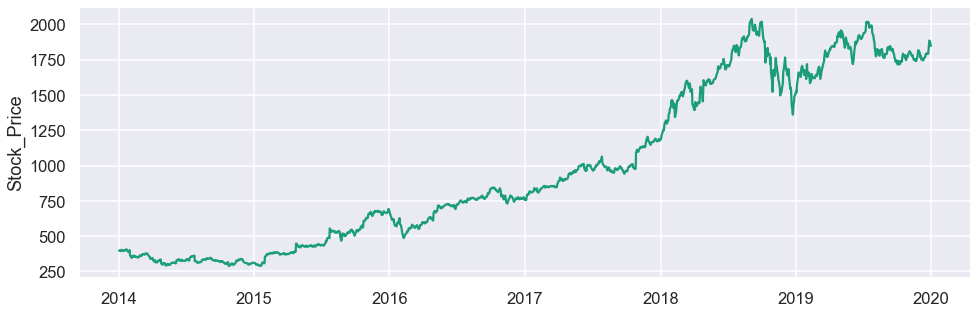

In [272]:
fig, (ax1) = plt.subplots(1, 1, figsize=(16,5))
ax1.plot(X.index,X['Stock_Price'])
ax1.set_ylabel('Stock_Price')

In [273]:
y = X.Stock_Price

In [274]:
X.drop(['Stock_Price'],inplace = True,axis=1)

In [275]:
rf = RandomForest(x=X,y=y,n_trees=30,n_features=3,sample_sz=100)

In [276]:
tree = rf.create_tree()

In [277]:
y_pred = rf.predict(X.tail(90).values)

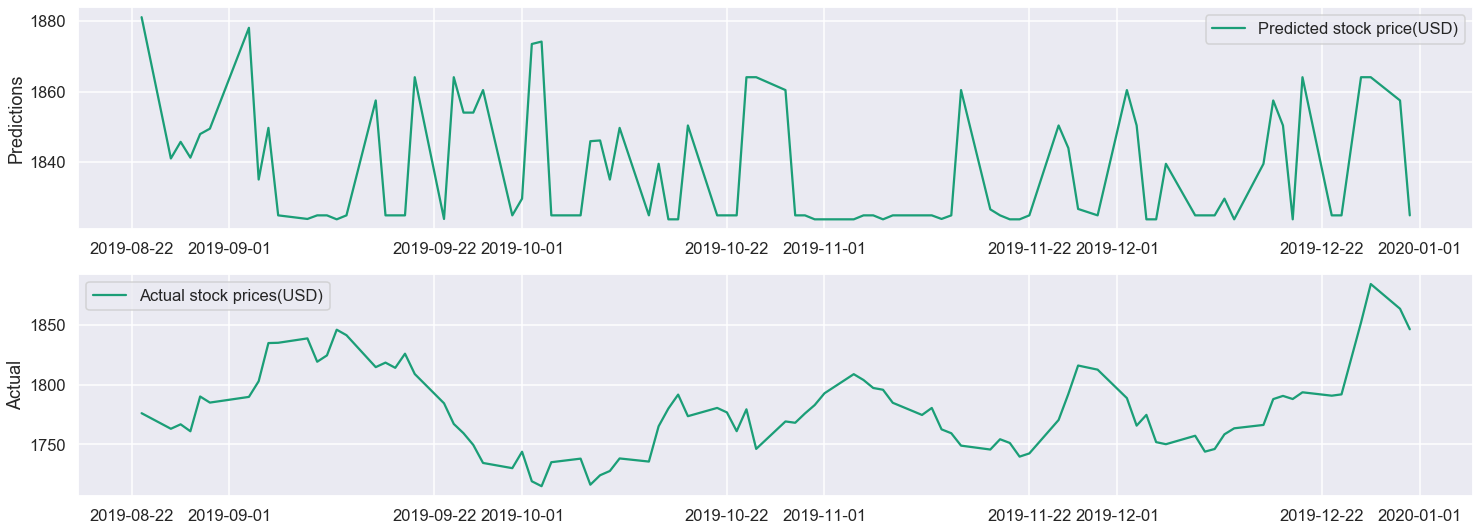

In [305]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,9))
ax1.plot(X.tail(90).index,y_pred,label="Predicted stock price(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.plot(X.tail(90).index,y.tail(90),label="Actual stock prices(USD)")
ax2.legend(loc='best')

In [279]:
# exponential weighted functions
ema_short = X.ewm(span=7, adjust=False).mean()

In [280]:
y_short = y.ewm(span=7, adjust=False).mean()

In [281]:
rf2 = RandomForest(x=ema_short,y=y_short,n_trees=30,n_features=3,sample_sz=100)

In [282]:
y_pred_short = rf.predict(ema_short.tail(90).values)

In [283]:
rf2.create_tree()

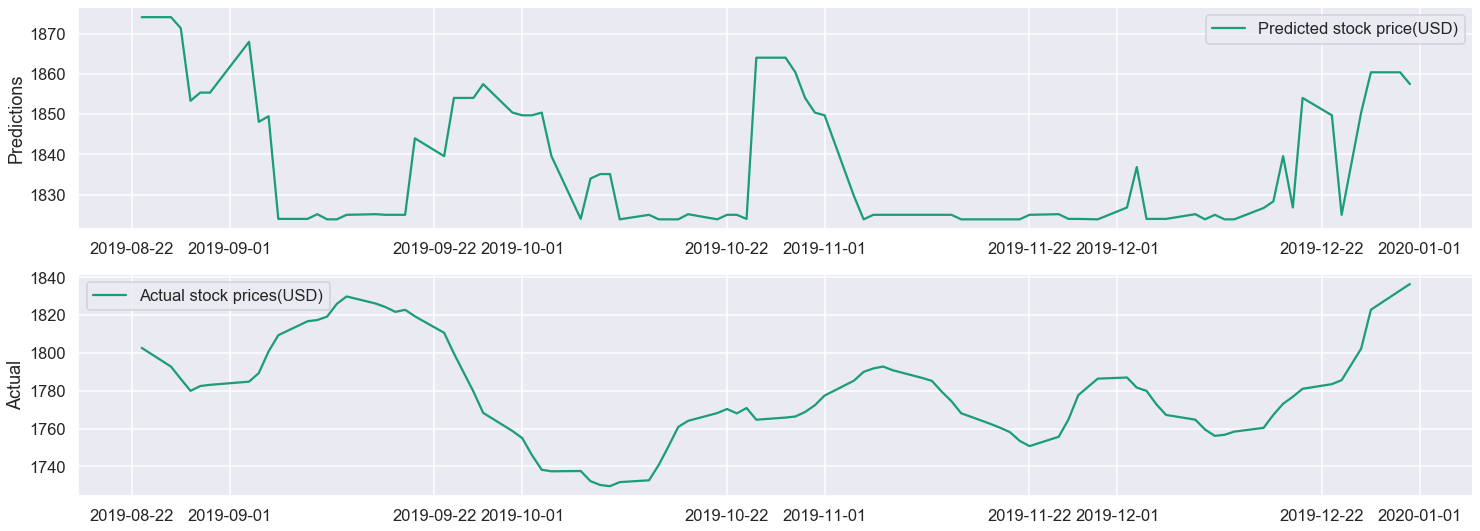

In [306]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(25,9))
ax1.plot(ema_short.tail(90).index,y_pred_short,label="Predicted stock price(USD)")
ax2.plot(X.tail(90).index,y_short.tail(90),label="Actual stock prices(USD)")
ax1.set_ylabel("Predictions")
ax2.set_ylabel("Actual")
ax1.legend(loc='best')
ax2.legend(loc='best')

In [285]:
trading_signal_week = pd.DataFrame(np.sign(np.diff(y_pred_short)),index=X.tail(89).index,columns=["signal"])

In [286]:
trading_signal_week.head()

,signal
Date,
2019-08-26,0.0
2019-08-27,-1.0
2019-08-28,-1.0
2019-08-29,1.0
2019-08-30,0.0


In [287]:
X.head()

,Volume,SP500
Date,,
2014-01-02,2137800,-1.389933
2014-01-03,2210200,-1.399417
2014-01-06,3170600,-1.407391
2014-01-07,1916000,-1.392983
2014-01-08,2316500,-1.391579


In [288]:
trading_signal_week = trading_signal_week.shift(1)

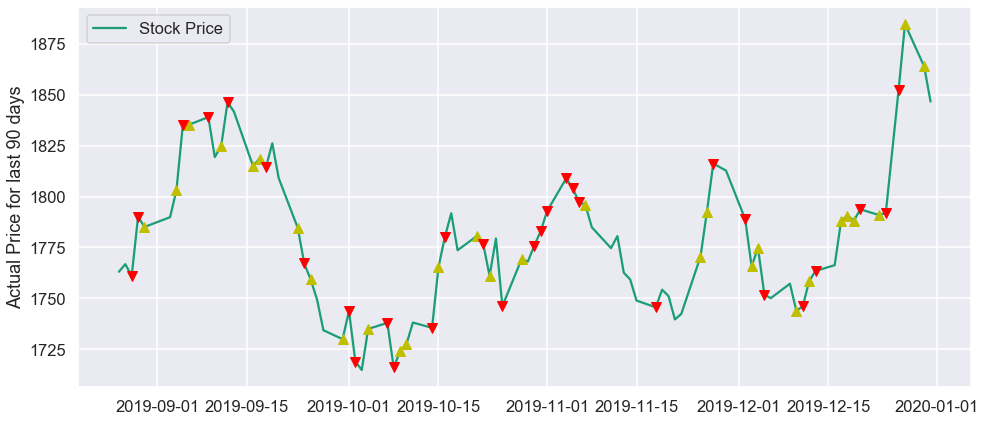

In [289]:
fig, (ax2) = plt.subplots(1, 1, figsize=(16,7))
duration = 89
y_temp = pd.DataFrame(y_short.tail(duration),index =X.tail(duration).index)
ax2.plot(X.tail(duration).index,y.tail(duration),label="Stock Price")

ax2.set_ylabel("Actual Price for last 90 days")

ax2.legend(loc='best')

# # Plot the buy signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == 1.0].index, 
         y.tail(duration)[trading_signal_week.signal == 1.0],'^', markersize=10, color='y')

# Plot the sell signals
ax2.plot(trading_signal_week.tail(duration).loc[trading_signal_week.signal == -1.0].tail(duration).index, 
         y.tail(duration)[trading_signal_week.signal == -1.0],'v', markersize=10, color='r')

In [297]:
# Set the initial capital
initial_capital= float(10000.0)

# Create a DataFrame 'positions'
positions = pd.DataFrame(index=trading_signal_week.index).fillna(0.0)

# Buy
positions['stock_price'] = trading_signal_week['signal'] 
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(y_short.tail(90), axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add 'holdings' to portfolio
portfolio['holdings'] = (positions.multiply(y_short.tail(90), axis=0)).sum(axis=1)

# Add 'cash' to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(y_short.tail(90), axis=0)).sum(axis=1).cumsum()   

# Add 'total' & 'returns' to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

portfolio['returns'] = portfolio['total'].pct_change()

In [298]:
portfolio = portfolio.loc["2019-08-01":]

In [299]:
portfolio

,stock_price,holdings,cash,total,returns
Date,,,,,
2019-08-23,NaN,0.000000,10000.000000,10000.000000,NaN
2019-08-26,NaN,0.000000,10000.000000,10000.000000,0.000000
2019-08-27,0.000000,0.000000,10000.000000,10000.000000,0.000000
2019-08-28,-1779.993523,-1779.993523,11779.993523,10000.000000,0.000000
2019-08-29,-1782.542025,-1782.542025,11779.993523,9997.451498,-0.000255
...,...,...,...,...,...
2019-12-24,-1785.649857,-1785.649857,11801.287320,10015.637463,0.000211
2019-12-26,-1802.311764,-1802.311764,11801.287320,9998.975556,-0.001664
2019-12-27,1822.896955,1822.896955,8155.493410,9978.390365,-0.002059


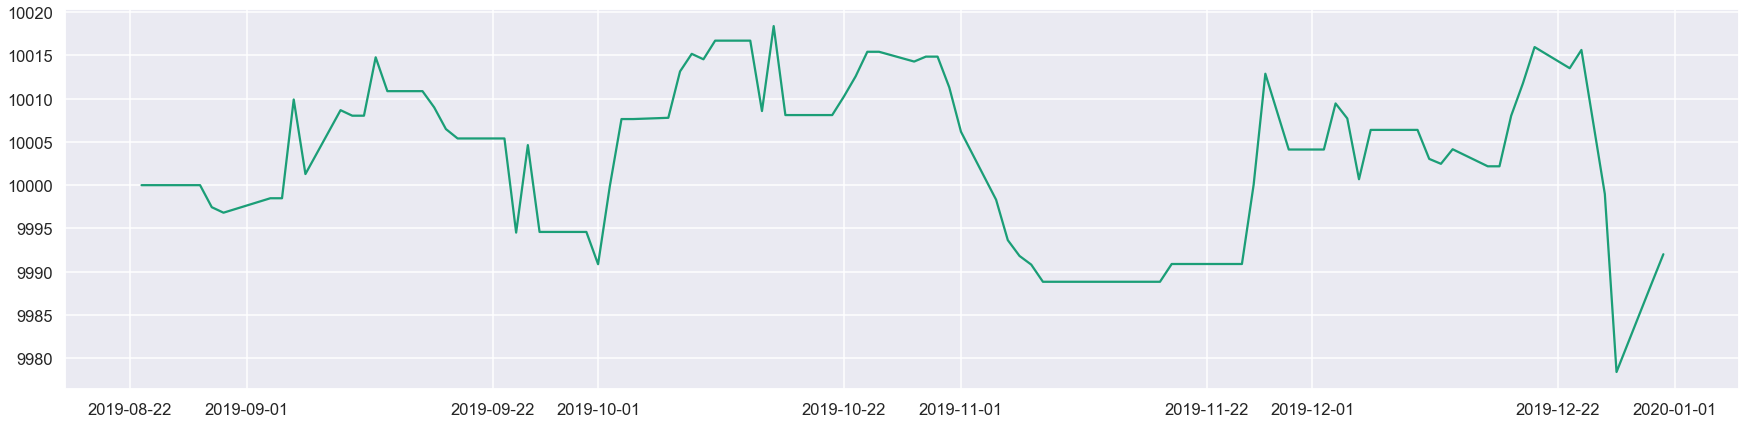

In [300]:
fig, ax1 = plt.subplots(1, 1, figsize=(30,7))
duration = 89
ax1.plot(portfolio['total'])

In [301]:
# Isolate the returns of the strategy
returns = portfolio['returns']
print(returns)
# 90 day Sharpe ratio
#sharpe_ratio = np.sqrt(90) * (returns.mean() / returns.std())

# Print the Sharpe ratio
#print(sharpe_ratio)

Date
2019-08-23         NaN
2019-08-26    0.000000
2019-08-27    0.000000
2019-08-28    0.000000
2019-08-29   -0.000255
                ...   
2019-12-24    0.000211
2019-12-26   -0.001664
2019-12-27   -0.002059
2019-12-30    0.001027
2019-12-31    0.000338
Name: returns, Length: 90, dtype: float64


In [302]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rms = sqrt(mean_squared_error(y_short.tail(90), y_pred_short))

In [303]:
rms

64.43764964440244